Only Yuan should make changes to this file. 

The downside of EBM is that it seems to only be able to handle pairwise interactions. 

In [14]:
import pandas as pd

In [15]:
import numpy as np

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [17]:
import sys 
sys.path.append("../../")

In [18]:
from proj_mod import drop_extreme

In [19]:
from proj_mod import data_shifting

In [20]:
all_data=pd.read_csv("../../data/processed/all_data_collection.csv")

In [21]:
all_data.columns

Index(['Date', 'tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change', 'fed_dff_daily',
       'ppi314_monthly_pro_change', 'ppi332_monthly_pro_change',
       'ppi333_monthly_pro_change', 'ppi334_monthly_pro_change',
       'ppi335_monthly_pro_change', 'ppi336_monthly_pro_change',
       'ppi339_monthly_pro_change', 'ppi516_monthly_pro_change',
       'ppi517_monthly_pro_change', 'ppi5132_monthly_pro_change',
       'ppi5182_monthly_pro_change'],
      dtype='object')

In [22]:
all_data_extended = all_data.copy(deep=True)

In [23]:
lst_cols_shift=['tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change']

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
#import numpy as np
#import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

In [27]:
arr_mse_kfold_collection=[] #Each row is for one int_extend. Then for each row index zero is for the training with extreme values, and index one is for the training without extreme values. 
for int_extend in range(11): 
    if int_extend != 0: 
        for col in lst_cols_shift: 
            all_data_extended=data_shifting.shifter(df_in=all_data_extended,str_col=col,int_shift=int_extend)
    all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
    all_data_extended_de=drop_extreme.drop_by_sort(df_in=all_data_extended.dropna(),fl_low=0.001,fl_high=0.999)
    all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]
    all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()
    X_train=all_data_extended_train.iloc[:,2:]
    y_train=all_data_extended_train.iloc[:,1]
    X_de_train=all_data_extended_train_de.iloc[:,2:]
    y_de_train=all_data_extended_train_de.iloc[:,1]
    X_test=all_data_extended_test.iloc[:,2:]
    y_test=all_data_extended_test.iloc[:,1]
    ebm_pipe=Pipeline([("std",StandardScaler()),("ebm",ExplainableBoostingRegressor())])
    time_kfold=TimeSeriesSplit(n_splits=5)
    fold_mse=[]
    #First for without deleting extreme values. 
    for index_train, index_test in time_kfold.split(X_train): 
        X_tt=X_train.iloc[index_train]
        y_tt=y_train.iloc[index_train]
        X_ho=X_train.iloc[index_test]
        y_ho=y_train.iloc[index_test]
        ebm_pipe.fit(X=X_tt,y=y_tt)
        pred=ebm_pipe.predict(X=X_ho)
        error=mean_squared_error(y_pred=pred,y_true=y_ho)
        fold_mse.append(error)
    mean_error=np.mean(fold_mse)
    arr_mse_kfold_collection.append([])
    arr_mse_kfold_collection[-1].append(mean_error)
    print("mse trained on"+str(int_extend)+"index shifting and WITHOUT deleting extreme values is"+str(mean_error)+" with k fold.")
    fold_mse=[]
    #Then the one with deleting extreme values. 
    for index_train, index_test in time_kfold.split(X_de_train): 
        X_tt=X_de_train.iloc[index_train]
        y_tt=y_de_train.iloc[index_train]
        X_ho=X_de_train.iloc[index_test]
        y_ho=y_de_train.iloc[index_test]
        ebm_pipe.fit(X=X_tt,y=y_tt)
        pred=ebm_pipe.predict(X=X_ho)
        error=mean_squared_error(y_pred=pred,y_true=y_ho)
        fold_mse.append(error)
    mean_error=np.mean(fold_mse)
    arr_mse_kfold_collection[-1].append(mean_error)
    print("mse trained on"+str(int_extend)+"index shifting and WITH deleting extreme values is"+str(mean_error)+" with k fold.")
    print("\n"+"Finished training and testing for"+str(int_extend)+"shiftings.")
        

/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on0index shifting and WITHOUT deleting extreme values is2.051944388448648 with k fold.
mse trained on0index shifting and WITH deleting extreme values is1.7576927222126666 with k fold.

Finished training and testing for0shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on1index shifting and WITHOUT deleting extreme values is2.070425347837615 with k fold.
mse trained on1index shifting and WITH deleting extreme values is1.7057707864102727 with k fold.

Finished training and testing for1shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on2index shifting and WITHOUT deleting extreme values is2.0884629300608557 with k fold.
mse trained on2index shifting and WITH deleting extreme values is1.651095200997854 with k fold.

Finished training and testing for2shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on3index shifting and WITHOUT deleting extreme values is2.107957151616473 with k fold.
mse trained on3index shifting and WITH deleting extreme values is1.6559600798990075 with k fold.

Finished training and testing for3shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on4index shifting and WITHOUT deleting extreme values is2.1029202129550577 with k fold.
mse trained on4index shifting and WITH deleting extreme values is1.6642799039431821 with k fold.

Finished training and testing for4shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on5index shifting and WITHOUT deleting extreme values is2.1369017999340456 with k fold.
mse trained on5index shifting and WITH deleting extreme values is1.6200178218470402 with k fold.

Finished training and testing for5shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on6index shifting and WITHOUT deleting extreme values is2.129709792018569 with k fold.
mse trained on6index shifting and WITH deleting extreme values is1.657976167692689 with k fold.

Finished training and testing for6shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on7index shifting and WITHOUT deleting extreme values is2.1205872657641796 with k fold.
mse trained on7index shifting and WITH deleting extreme values is1.646403466953385 with k fold.

Finished training and testing for7shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on8index shifting and WITHOUT deleting extreme values is2.1044418245256233 with k fold.
mse trained on8index shifting and WITH deleting extreme values is1.6511111058143038 with k fold.

Finished training and testing for8shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on9index shifting and WITHOUT deleting extreme values is2.0743912555013244 with k fold.
mse trained on9index shifting and WITH deleting extreme values is1.6769290393962788 with k fold.

Finished training and testing for9shiftings.


/tmp/ipykernel_45933/3429884842.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


mse trained on10index shifting and WITHOUT deleting extreme values is2.102988377304958 with k fold.
mse trained on10index shifting and WITH deleting extreme values is1.6907890849878586 with k fold.

Finished training and testing for10shiftings.


This is a record of the arr_mse_kfold_collection: 
[[2.051944388448648, 1.7576927222126666],
 [2.070425347837615, 1.7057707864102727],
 [2.0884629300608557, 1.651095200997854],
 [2.107957151616473, 1.6559600798990075],
 [2.1029202129550577, 1.6642799039431821],
 [2.1369017999340456, 1.6200178218470402],
 [2.129709792018569, 1.657976167692689],
 [2.1205872657641796, 1.646403466953385],
 [2.1044418245256233, 1.6511111058143038],
 [2.0743912555013244, 1.6769290393962788],
 [2.102988377304958, 1.6907890849878586]]

In [31]:
np.array(arr_mse_kfold_collection).transpose()


array([[2.05194439, 2.07042535, 2.08846293, 2.10795715, 2.10292021,
        2.1369018 , 2.12970979, 2.12058727, 2.10444182, 2.07439126,
        2.10298838],
       [1.75769272, 1.70577079, 1.6510952 , 1.65596008, 1.6642799 ,
        1.62001782, 1.65797617, 1.64640347, 1.65111111, 1.67692904,
        1.69078908]])

In [32]:
df_error=pd.DataFrame({"WITH extreme":np.array(arr_mse_kfold_collection).transpose()[0], "WITHOUT extreme":np.array(arr_mse_kfold_collection).transpose()[1]})

In [36]:
df_error.index

RangeIndex(start=0, stop=11, step=1)

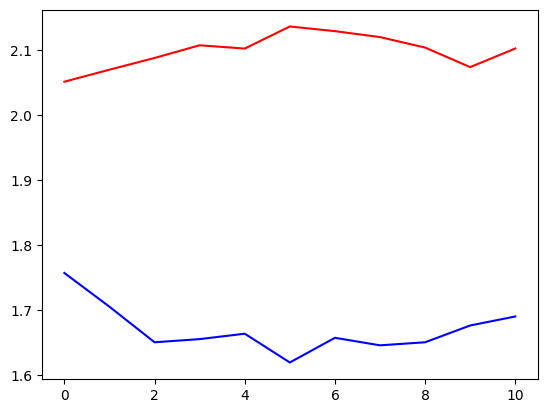

In [38]:
plt.plot(df_error["WITH extreme"].values, c="r")
plt.plot(df_error["WITHOUT extreme"].values, c="b")
plt.show()

Seemingly we should take the no extreme model with 5 shiftings and the model with extreme without shiftings. 

We first train the one without extreme values, tested on both test data with and without extremes. 

In [70]:
all_data_extended = all_data.copy(deep=True)

In [71]:
for int_extend in range(6): 
    if int_extend != 0: 
        for col in lst_cols_shift: 
            all_data_extended=data_shifting.shifter(df_in=all_data_extended,str_col=col,int_shift=int_extend)

In [72]:
all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()

In [73]:
all_data_extended_de=drop_extreme.drop_by_sort(df_in=all_data_extended.dropna(),fl_low=0.001,fl_high=0.999)
all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]
all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()

/tmp/ipykernel_45933/3207107995.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data_extended_train_de=all_data_extended_de[all_data_extended["Date"]<"2024-01-01"]


In [74]:
all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)

In [75]:
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
X_de_train=all_data_extended_train_de.iloc[:,2:]
y_de_train=all_data_extended_train_de.iloc[:,1]
X_test=all_data_extended_test.iloc[:,2:]
y_test=all_data_extended_test.iloc[:,1]

In [76]:
X_de_test=all_data_extended_test_de.iloc[:,2:]
y_de_test=all_data_extended_test_de.iloc[:,1]

In [77]:
ebm_pipe=Pipeline([("std",StandardScaler()),("ebm",ExplainableBoostingRegressor())])

In [78]:
ebm_pipe.fit(X=X_de_train,y=y_de_train)

Pipeline(steps=[('std', StandardScaler()),
                ('ebm', ExplainableBoostingRegressor())])

First, test on the test set with extreme values. 

In [79]:
pred_extreme=ebm_pipe.predict(X=X_test)

In [80]:
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

In [81]:
mse_extreme

1.8075930170995083

<function matplotlib.pyplot.show(close=None, block=None)>

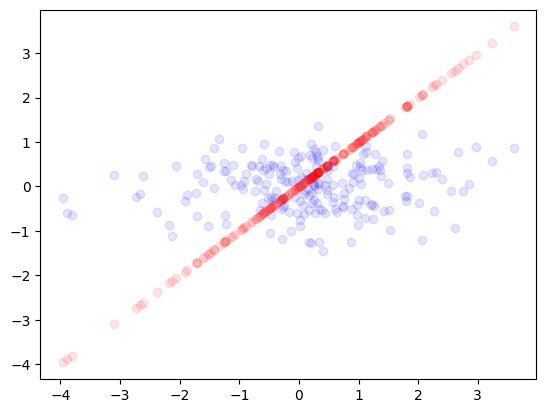

In [85]:
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1)
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1)
plt.show

Then, test on the test set without extreme values. 

In [82]:
pred_noextreme=ebm_pipe.predict(X=X_de_test)

In [83]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

In [84]:
mse_noextreme

1.7424172578256487

<function matplotlib.pyplot.show(close=None, block=None)>

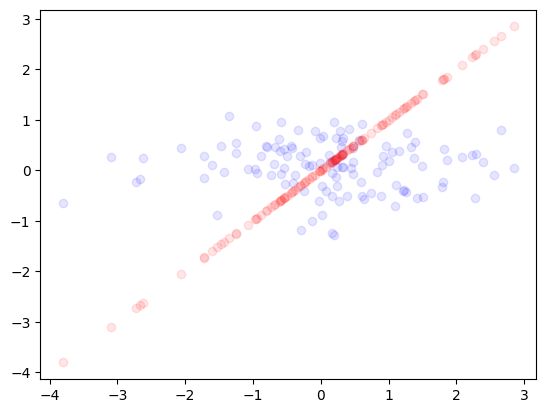

In [87]:
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1)
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1)
plt.show

This is a shit model :(.

In [89]:
all_data_train=all_data[all_data_extended["Date"]<"2024-01-01"]

In [91]:
all_data_test=all_data[all_data_extended["Date"]>="2024-01-01"]

In [92]:
X_train=all_data_train.iloc[:,2:]
y_train=all_data_train.iloc[:,1]
X_test=all_data_test.iloc[:,2:]
y_test=all_data_test.iloc[:,1]

In [93]:
ebm_pipe=Pipeline([("std",StandardScaler()),("ebm",ExplainableBoostingRegressor())])

In [94]:
ebm_pipe.fit(X=X_train,y=y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('ebm', ExplainableBoostingRegressor())])

In [95]:
pred=ebm_pipe.predict(X=X_test)

In [96]:
mse=mean_squared_error(y_pred=pred,y_true=y_test)

In [97]:
mse

1.5693757032022133

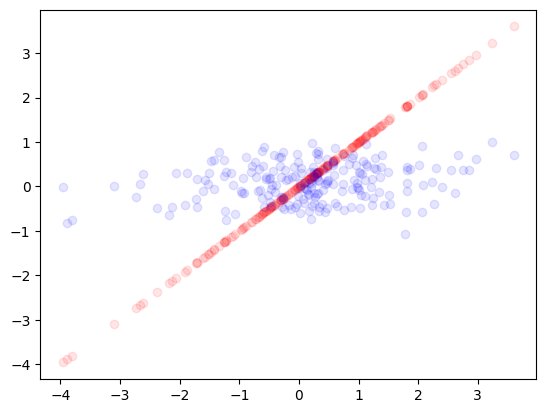

In [98]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1)
plt.scatter(x=y_test,y=pred,c="b",alpha=0.1)
plt.show()

Shit again. 